# Accelerator

In [64]:
!pip install -q scikit-learn-intelex
!pip install tensorflow

In [65]:
from sklearnex import patch_sklearn
patch_sklearn("SVC")

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


# Import libraries

In [66]:
from IPython.display import HTML, Image
from google.colab.output import eval_js
from google.colab.patches import cv2_imshow
from base64 import b64decode
from timeit import default_timer as timer

import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.datasets import load_digits, fetch_openml
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.svm import SVC

import warnings

# Suppress all warnings
warnings.filterwarnings("ignore")



import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout
print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.17.1


# Dataset

In [67]:
# Load dataset from OpenML
mnist = fetch_openml('mnist_784', version=1)
X, y = mnist['data'], mnist['target']

Explain: 784 = 28x28 so all of images are size 28x28 pixcels then flatten we get feature vectors

In [68]:
print(f"Data shape: {X.shape}")
print(f"Labels shape: {y.shape}")

Data shape: (70000, 784)
Labels shape: (70000,)


Nomalization:

*   With y values must be integer type
*   X vector gonna divide by 255.0 into values between 0 - 1.0 . This will make the caculation faster



In [69]:
y = y.astype(int)
X = (X / 255.0).to_numpy()

Split data: We will spit my data into 2 sets {train, test}. With test size is 0.2 this says that
* Number samples of test set / total samples = 0.2 -> test_size = 70.000 * 0.2 = 14.000 samples.
* And the rest train_size = 56.000 samples

In [70]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Visualize

In [71]:
def show_images(images, labels, type_label="Label", title="Visualize"):
    fig, axes = plt.subplots(3, 6, figsize=(12, 6))  # 3 rows, 6 columns
    axes = axes.flatten()  # Flatten the axes array to easily iterate over it

    for i, (img, label) in enumerate(zip(images, labels)):
        axes[i].imshow(img.reshape(28, 28), cmap='gray')
        axes[i].set_title(f'{type_label}: {label}')
        axes[i].axis('off')

    # Turn off axes for any extra subplots that are not used
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    # Set the title for the entire figure
    fig.suptitle(title, fontsize=20)

    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to fit the suptitle
    plt.show()

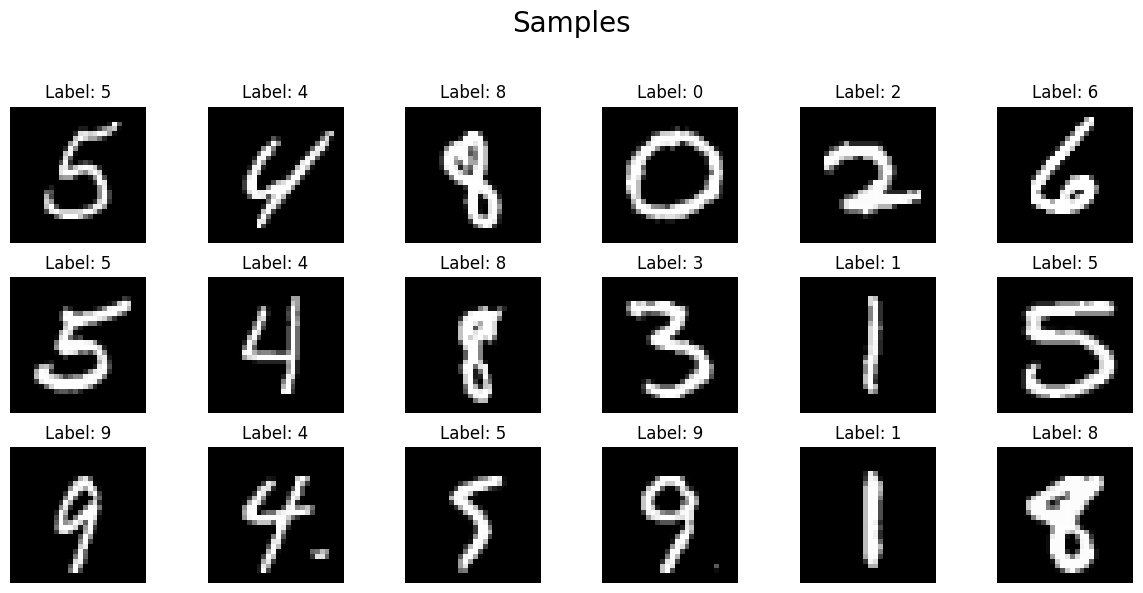

In [72]:
show_images(X_train[:18], y_train[:18], title="Samples")

# SVM Model

Below cell using Gird Search to find best hyperparameters but i haven't finished it yet because it runs quite long despite the support of accelertor. So you should run the below its .

In [73]:
# Survey 3 hyperparameters {kernel, C, gamma}
parameters = {
                'kernel':('linear', 'poly', 'rbf', 'sigmoid'),
                'C':[1, 50, 100],
                'gamma': ('auto', "scale"),
                "max_iter": [500]
            }
svc = SVC()
cls = GridSearchCV(svc, parameters)

In [74]:
cls = SVC(kernel="rbf", C=100, gamma="scale")

## Train

In [75]:
start = timer()
cls.fit(X_train, y_train)
train_patched = timer() - start

print("Training time:", train_patched)

Training time: 108.18644705799989


In [76]:
# Run this cell if you use gridsearch. That will show for you best parameters
# print("Best parameters:", cls.best_params_)

## Test

In [77]:
y_predict = cls.predict(X_test)
report = metrics.classification_report(y_test, y_predict)
print(f"Classification report for SVM:\n{report}\n")

Classification report for SVM:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1343
           1       0.99      0.99      0.99      1600
           2       0.97      0.98      0.98      1380
           3       0.98      0.98      0.98      1433
           4       0.98      0.98      0.98      1295
           5       0.98      0.98      0.98      1273
           6       0.99      0.99      0.99      1396
           7       0.98      0.98      0.98      1503
           8       0.98      0.97      0.98      1357
           9       0.98      0.97      0.97      1420

    accuracy                           0.98     14000
   macro avg       0.98      0.98      0.98     14000
weighted avg       0.98      0.98      0.98     14000




In [78]:
correct_indices = np.where(y_predict == y_test)[0]
error_indices = np.where(y_predict != y_test)[0]

X_test_correct = X_test[correct_indices][:18]
y_predict_correct = y_predict[correct_indices][:18]

X_test_error = X_test[error_indices][:18]
y_predict_error = y_predict[error_indices][:18]

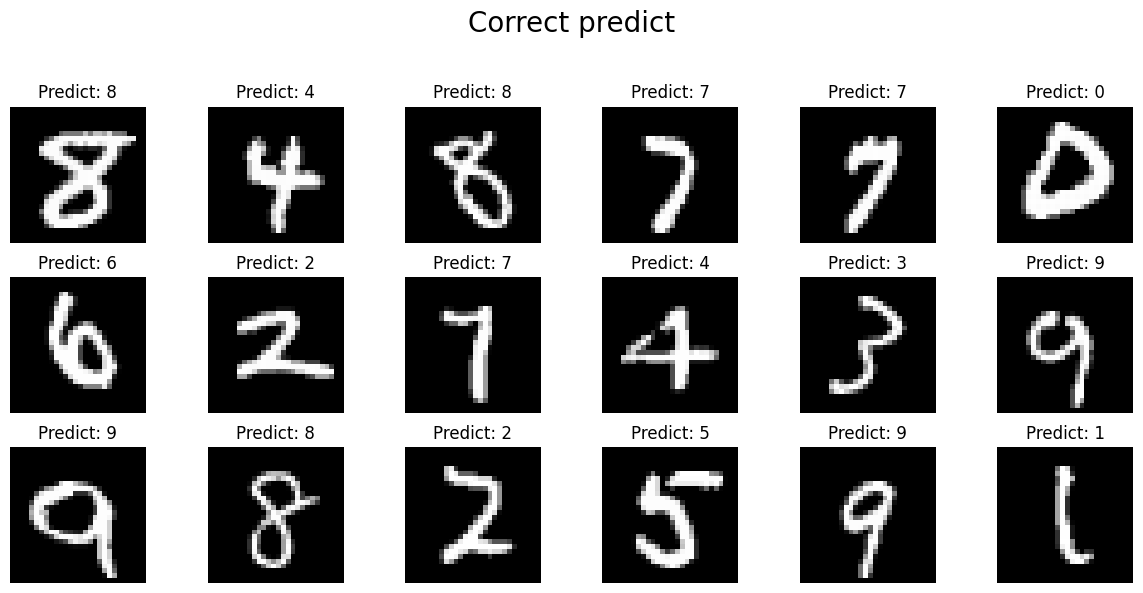

In [79]:
show_images(X_test_correct, y_predict_correct, type_label = "Predict", title="Correct predict")

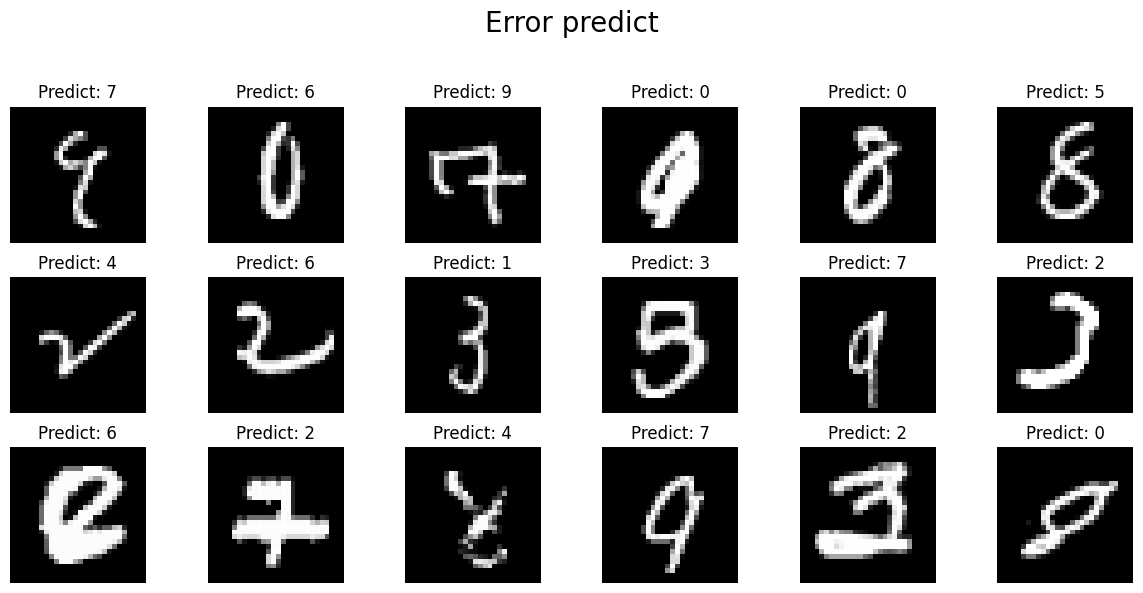

In [80]:
show_images(X_test_error, y_predict_error, type_label = "Predict", title="Error predict")

# CNN Model


In [81]:
X_train_cnn = X_train.reshape(-1, 28, 28, 1)
X_test_cnn = X_test.reshape(-1, 28, 28, 1)

print("Shape of X_train_cnn:", X_train_cnn.shape)
print("Shape of X_test_cnn:", X_test_cnn.shape)


Shape of X_train_cnn: (56000, 28, 28, 1)
Shape of X_test_cnn: (14000, 28, 28, 1)


In [82]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization

# Định nghĩa mô hình CNN chính xác hơn
def create_cnn_model():
    model = Sequential([
        # Block 1
        Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),

        # Block 2
        Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),

        # Block 3
        Conv2D(filters=128, kernel_size=(3, 3), activation='relu'),
        BatchNormalization(),
        Dropout(0.4),

        # Flatten + Dense layers
        Flatten(),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),

        # Output layer
        Dense(10, activation='softmax')  # MNIST có 10 lớp (0-9)
    ])
    return model

# Khởi tạo mô hình
model = create_cnn_model()

# Compile mô hình
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# In kiến trúc mô hình
model.summary()



Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)                    │ (None, 26, 26, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 26, 26, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 13, 13, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 13, 13, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 11, 11, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 11, 11, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 5, 5, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 5, 5, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 3, 3, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 3, 3, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 3, 3, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 1152)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 242,954 (949.04 KB)

 Trainable params: 242,250 (946.29 KB)

 Non-trainable params: 704 (2.75 KB)

In [83]:
# Huấn luyện mô hình CNN
epochs = 10
batch_size = 64

history = model.fit(
    X_train_cnn,  # Dữ liệu huấn luyện đã reshape (batch_size, 28, 28, 1)
    y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_split=0.1,  # 10% tập huấn luyện để làm validation
    verbose=1
)
train_time_cnn = timer() - start_cnn

print(f"CNN training time: {train_time_cnn:.2f} seconds")


Epoch 1/10
788/788 ━━━━━━━━━━━━━━━━━━━━ 14s 10ms/step - accuracy: 0.8215 - loss: 0.5970 - val_accuracy: 0.9711 - val_loss: 0.0873
Epoch 2/10
788/788 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.9681 - loss: 0.1040 - val_accuracy: 0.9891 - val_loss: 0.0371
Epoch 3/10
788/788 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9766 - loss: 0.0767 - val_accuracy: 0.9884 - val_loss: 0.0366
Epoch 4/10
788/788 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9810 - loss: 0.0632 - val_accuracy: 0.9911 - val_loss: 0.0290
Epoch 5/10
788/788 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9824 - loss: 0.0585 - val_accuracy: 0.9920 - val_loss: 0.0258
Epoch 6/10
788/788 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9839 - loss: 0.0511 - val_accuracy: 0.9925 - val_loss: 0.0262
Epoch 7/10
788/788 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.9864 - loss: 0.0437 - val_accuracy: 0.9932 - val_loss: 0.0237
Epoch 8/10
788/788 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9859 - loss: 0.0440 - val_accuracy:

In [84]:
# Đánh giá trên tập test
test_loss, test_acc = model.evaluate(X_test_cnn, y_test, verbose=0)
print(f"CNN Test Accuracy: {test_acc:.4f}")

# Classification report
y_pred_cnn = model.predict(X_test_cnn)
y_pred_cnn_labels = np.argmax(y_pred_cnn, axis=1)
report_cnn = metrics.classification_report(y_test, y_pred_cnn_labels)

print("Classification Report (CNN):")
print(report_cnn)


CNN Test Accuracy: 0.9921
438/438 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Classification Report (CNN):
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      1343
           1       0.99      1.00      1.00      1600
           2       0.98      1.00      0.99      1380
           3       0.99      0.99      0.99      1433
           4       0.99      0.99      0.99      1295
           5       1.00      0.99      0.99      1273
           6       0.99      1.00      0.99      1396
           7       1.00      0.99      0.99      1503
           8       0.99      0.98      0.99      1357
           9       0.99      0.99      0.99      1420

    accuracy                           0.99     14000
   macro avg       0.99      0.99      0.99     14000
weighted avg       0.99      0.99      0.99     14000



# Immplement

In [85]:
canvas_html = """
<canvas width=%d height=%d style="background-color: lightblue; border: 2px solid black;"></canvas>
<button>Finish</button>
<script>
var canvas = document.querySelector('canvas')
var ctx = canvas.getContext('2d')
ctx.lineWidth = %d
var button = document.querySelector('button')
var mouse = {x: 0, y: 0}
canvas.addEventListener('mousemove', function(e) {
  mouse.x = e.pageX - this.offsetLeft
  mouse.y = e.pageY - this.offsetTop
})
canvas.onmousedown = ()=> {
  ctx.beginPath()
  ctx.moveTo(mouse.x, mouse.y)
  canvas.addEventListener('mousemove', onPaint)
}
canvas.onmouseup = ()=> {
  canvas.removeEventListener('mousemove', onPaint)
}
var onPaint = ()=> {
  ctx.lineTo(mouse.x, mouse.y)
  ctx.stroke()
}
var data = new Promise(resolve => {
  button.onclick = ()=> {
    resolve(canvas.toDataURL('image/png'))
  }
})
</script>
"""

def draw(filename='drawing.png', w=300, h=300, line_width=5):
    """
        Create a canva where you can draw .Then save this canva to a image.
        Args:
            filename: file name of image
            w: width of the canva
            h: height of the canva
            line_width: weight of line
    """
    display(HTML(canvas_html % (w, h, line_width)))
    data = eval_js("data")
    binary = b64decode(data.split(',')[1])
    with open(filename, 'wb') as f:
        f.write(binary)

In [86]:
def get_gray_image(path_image):
    image = cv2.imread(path_image, cv2.IMREAD_UNCHANGED)
    b, g, r, alpha = cv2.split(image)
    white_background = np.ones_like(b, dtype=np.uint8) * 255
    b = cv2.bitwise_and(b, alpha) + cv2.bitwise_and(white_background, cv2.bitwise_not(alpha))
    g = cv2.bitwise_and(g, alpha) + cv2.bitwise_and(white_background, cv2.bitwise_not(alpha))
    r = cv2.bitwise_and(r, alpha) + cv2.bitwise_and(white_background, cv2.bitwise_not(alpha))

    merged_image = cv2.merge((b, g, r))

    gray_image = cv2.cvtColor(merged_image, cv2.COLOR_BGR2GRAY)
    inverted_image = cv2.bitwise_not(gray_image)
    cv2_imshow(inverted_image)
    img_resize = cv2.resize(inverted_image, (28, 28))
    img_nomal = img_resize / 255.0
    img_nomal = np.where(img_nomal > 0.1, 1, 0)
    return img_nomal

def immplement(file_name="image.png"):
    draw(filename=file_name, w=200, h=200, line_width=15)
    img_draw = get_gray_image(file_name)
    feature = img_draw.flatten()
    y_pred = cls.predict([feature])
    print("Predict the image SVM:", y_pred[0])

    img_cnn = img_draw.reshape(1, 28, 28, 1)
    y_pred_cnn = model.predict(img_cnn)
    y_pred_cnn_label = np.argmax(y_pred_cnn, axis=1)
    print("Predict the image with CNN:", y_pred_cnn_label[0])



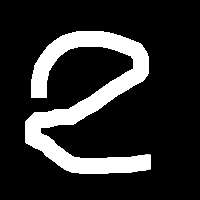

Predict the image SVM: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Predict the image with CNN: 3


In [108]:
immplement()